### DCT3SNN - DCT-2 Encoded Dataset

The dataset is encoded using the padded generator matrix. the imaginary and real values are parellel processed until concatenation. The parallel execution mimics the DCT-III SNN. One additional layer is included to account for the scaling diagonal matrix $\hat{D}_n$ in the classical algorithm.

In [1]:
# (r + 1) | (q - 1)
# (r + 1) | n
# q is a prime number
# n = 2^t
# r < n

sample test on logic used:

In [2]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.fftpack import dct

x = np.random.randint(0, 5, 16)
print("we don't know what x is:", x)
N = len(x)
X_dft = fft(x)
print("\nwhat we are given: ", X_dft)

k = np.arange(N)
phase_shift = np.exp(-1j * np.pi * k / (2 * N))
alpha_k = np.where(k == 0, np.sqrt(1/N), np.sqrt(2/N))
X_dct = np.real(alpha_k * phase_shift * X_dft)
print("\nDCT coefficients constructed using given fft: ", X_dct)

X = dct(X_dct, type=3, norm='ortho')
print("\nReconstructed signal: ", np.round(X))

perm = np.concatenate((X[::2], X[1::2][::-1])) # even indexes + odd indexes - reversed order
print("\nAfter permutation: ", np.round(perm))

we don't know what x is: [2 3 3 4 1 1 0 0 1 1 4 0 4 4 3 0]

what we are given:  [31.        -0.j          6.94075665+4.13918073j -5.53553391-6.12132034j
 -6.11600343-1.63664851j -2.        -5.j          5.2875763 -1.29350276j
  1.53553391+1.87867966j -2.11232953-7.51767352j  5.        -0.j
 -2.11232953+7.51767352j  1.53553391-1.87867966j  5.2875763 +1.29350276j
 -2.        +5.j         -6.11600343+1.63664851j -5.53553391+6.12132034j
  6.94075665-4.13918073j]

DCT coefficients constructed using given fft:  [ 7.75        2.58555209 -2.34171864 -2.23719547 -1.32977661  1.43311912
  0.8204165  -2.2634539   1.25        1.58080529 -0.25065808  1.28457041
  1.36260566 -0.07396588  1.74081621 -1.2158476 ]

Reconstructed signal:  [ 2.  0.  3.  3.  3.  4.  4.  4.  1. -0.  1.  4. -0.  1.  0.  1.]

After permutation:  [ 2.  3.  3.  4.  1.  1. -0.  0.  1.  1.  4. -0.  4.  4.  3.  0.]


In [3]:
%reset -f
import gc
gc.collect()

0

In [4]:
# (x, y, z, w) --> (1, 2, 3, 4)
global z0
global w0

z0 = 3
w0 = 4

n = 16
q = 5

global r
r = 3

num_samples = 1000

In [5]:
import numpy as np
import pandas as pd

np.random.seed(42)

def next_power_of_two(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

n_padded = next_power_of_two(n)

dataset = np.random.randint(0, q, size=(num_samples, n))

if n_padded > n:
    pad_width = n_padded - n
    dataset = np.pad(dataset, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

print("Original n:", n)
print("Padded n:", n_padded)
print("Generated dataset shape:", dataset.shape)

Original n: 16
Padded n: 16
Generated dataset shape: (1000, 16)


In [6]:
print(dataset)
print(dataset.shape)
print(dataset[0].shape)

[[3 4 2 ... 1 3 1]
 [3 4 0 ... 3 2 3]
 [3 0 2 ... 0 1 4]
 ...
 [4 4 4 ... 0 2 2]
 [4 2 4 ... 4 0 0]
 [2 2 2 ... 0 4 2]]
(1000, 16)
(16,)


$$
\tilde{M}_{kj} = \left[ \left( \frac{w_0}{z_0} \right)^j \zeta^{kj} \right]_{k,j=0}^{n-1}
$$

In [7]:
def padded_generator_matrix(N, w0, z0):
    n = np.arange(N)
    k = n.reshape((N, 1))
    zeta = np.exp(-2j * np.pi / N)
    M_tilde = ((w0 / z0) ** n) * (zeta ** (k * n))
    return M_tilde

In [8]:
M_tilde = padded_generator_matrix(n_padded, w0, z0)
print(M_tilde.shape)

(16, 16)


In [9]:
encoded_dataset = np.array([np.dot(M_tilde, x) for x in dataset])
encoded_dataset[np.abs(encoded_dataset) < 1e-10] = 0
encoded_dataset = np.round(encoded_dataset, decimals=10)
print(encoded_dataset)

[[ 649.89449698  +0.j           69.97998169+371.13335899j
   -83.92481787+137.40000024j ...  -88.37954911-103.22398682j
   -83.92481787-137.40000024j   69.97998169-371.13335899j]
 [ 695.87003951  +0.j          268.59479107+394.57072111j
   -36.50274968+309.16102475j ...  -47.36788425-179.88976988j
   -36.50274968-309.16102475j  268.59479107-394.57072111j]
 [ 540.63797786  +0.j          235.29809241+209.31041098j
   176.66145652+204.71795948j ...  108.87153914-320.22828928j
   176.66145652-204.71795948j  235.29809241-209.31041098j]
 ...
 [ 460.45123158  +0.j          162.64910275+168.11969395j
    54.45039471+219.81284778j ...  -26.91067254-124.72256855j
    54.45039471-219.81284778j  162.64910275-168.11969395j]
 [ 558.17613119  +0.j          -92.41727316+362.85897707j
  -228.64175513 +13.85662093j ...  -76.51498185+176.39278765j
  -228.64175513 -13.85662093j  -92.41727316-362.85897707j]
 [ 671.99178181  +0.j          161.97417378+352.04621278j
    43.09272997+244.01831359j ...  -56.208

In [10]:
encoded_dataset.shape

(1000, 16)

In [11]:
print(dataset[0])
print(encoded_dataset[0])

[3 4 2 4 4 1 2 2 2 4 3 2 4 1 3 1]
[ 649.89449698  +0.j           69.97998169+371.13335899j
  -83.92481787+137.40000024j  -88.37954911+103.22398682j
  -74.53901813 +41.73652084j  -97.48254893 +37.96448017j
 -147.95858217-108.15626408j   47.97234649-148.66691513j
  146.76987906  -0.j           47.97234649+148.66691513j
 -147.95858217+108.15626408j  -97.48254893 -37.96448017j
  -74.53901813 -41.73652084j  -88.37954911-103.22398682j
  -83.92481787-137.40000024j   69.97998169-371.13335899j]


In [12]:
k = np.arange(n_padded)
phase_shift = np.exp(-1j * np.pi * k / (2 * n_padded))
alpha_k = np.where(k == 0, np.sqrt(1/n_padded), np.sqrt(2/n_padded))

dct2_dataset = np.real(encoded_dataset * phase_shift) * alpha_k  # Apply transformation to entire dataset
dct2_dataset = np.round(dct2_dataset, 10)  # Round for numerical stability

print(dct2_dataset.shape)
print(dct2_dataset[0])

(1000, 16)
[ 162.47362425   37.48388585  -19.6246229   -19.30741408  -18.70056955
  -24.06835946  -64.73967959  -20.23391967   36.69246976   51.39054587
    2.73200003  -28.08438553  -23.71790458  -43.99421304  -53.43352006
 -128.1585124 ]


In [13]:
mean_real = np.mean(dct2_dataset, axis=0)
std_real = np.std(dct2_dataset, axis=0) + 1e-8  # Avoid division by zero
dct2_dataset = (dct2_dataset - mean_real) / std_real

print(dct2_dataset[0])

[ 0.31321882 -0.59372357 -0.75737619 -0.39345835 -0.21874733 -0.32403293
 -1.52746419 -0.03438707  1.4241565   1.49536555  0.66904188  0.11344868
  0.38536916  0.22891408  0.51751361 -0.53307882]


In [14]:
# normalize target data (integers 0-q to [0, 1])
y = dataset.astype(np.float32)
# y[:, :r] = 0
y_normalized = y / (q - 1)  # Scale to [0, 1]
print("y: ")
print(y[0])
print("\ny_normalized: ")
print(y_normalized[0])

labels = y_normalized

y: 
[3. 4. 2. 4. 4. 1. 2. 2. 2. 4. 3. 2. 4. 1. 3. 1.]

y_normalized: 
[0.75 1.   0.5  1.   1.   0.25 0.5  0.5  0.5  1.   0.75 0.5  1.   0.25
 0.75 0.25]


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dct2_dataset, labels, test_size=0.2, random_state=42
)

print("Training data shapes:", X_train.shape, "y:", y_train.shape)
print("Testing data shapes:", X_test.shape, "y:", y_test.shape)

Training data shapes: (800, 16) y: (800, 16)
Testing data shapes: (200, 16) y: (200, 16)


In [16]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
print(input_dim)
print(output_dim)

16
16


DCT-3 Structure Imposed Neural Network

In [17]:
import tensorflow as tf

In [18]:
class FirstLayer(tf.keras.layers.Layer):
  def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
    super(FirstLayer, self).__init__(**kwargs)
    self.units = units # features/neurons
    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
    self.use_bias = use_bias

  def build(self, input_shape):
    # input_shape --> (batch_size, input_dim)
    n = self.units
    n1 = n // 2
    
    self.d_1 = self.add_weight(name ="kernel_d1",
                               shape=(n1,),
                               initializer=tf.keras.initializers.get(self.kernel_initializer),
                              #  regularizer=tf.keras.regularizers.l2(1e-4),
                               trainable=True)
    self.d_2 = self.add_weight(name ="kernel_d2",
                               shape=(n1,),
                               initializer=tf.keras.initializers.get(self.kernel_initializer),
                              #  regularizer=tf.keras.regularizers.l2(1e-4),
                               trainable=True)
    if self.use_bias:
      self.bias = self.add_weight(name ="bias",
                                  shape=(self.units,),
                                  initializer=tf.keras.initializers.get(self.bias_initializer),
                                  # regularizer=tf.keras.regularizers.l2(1e-4),
                                  trainable=True)

  def call(self, inputs):
    # print("Enters first layer")
    P_n = tf.concat([inputs[:, ::2], inputs[:, 1::2]], axis=1) # permutation [x0, x2, x4, ..., xn-2, x1, x3, x5, ..., xn-1]
    out1 = P_n[:, :int(P_n.shape[1]/2)] # even indices [x0 x2 x4 ...]
    out2 = P_n[:, int(P_n.shape[1]/2):] # odd indices [x1 x3 x5 ...]
    
    # expected output for rearrange out2 after bidiagonal matrix ---> out2_n = [sqrt(2).x1, x1+x3, x3+x5+ ..., xn-3+xn-1]   
    
    out3 = tf.add(
      tf.multiply(out2, self.d_1), # diagonal
      tf.multiply(tf.concat([tf.zeros_like(out2[:, :1]), out2[:, :-1]], axis=1), self.d_2) # super diagonal
    )
    
    out = tf.concat([out1, out3], axis=1) # [x0 x2 x4 ... sqrt(2).x1, x1+x3, x3+x5+ ..., xn-3+xn-1]

    if self.use_bias:
      out += self.bias

    return out

In [ ]:
class SecondLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(SecondLayer, self).__init__(**kwargs)
        self.units = units  # Number of neurons/features
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        n1 = n // 2
        num_blocks = n1 // 2  # Number of 2×2 blocks needed for c1 and c2 (for 16 we need 4 blocks)

        self.d_1 = self.add_weight(name="kernel_d1",
                                   shape=(n1 - 2,),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.d_2 = self.add_weight(name="kernel_d2",
                                   shape=(n1 - 2,),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.w = self.add_weight(name="kernel_w",
                                 shape=(n1 - 2,),
                                 initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #  regularizer=tf.keras.regularizers.l2(1e-5),
                                 trainable=True)
    
        self.C_1 = self.add_weight(name="kernel_C_1",
                                   shape=(num_blocks, 2, 2),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.C_2 = self.add_weight(name="kernel_C_2",
                                   shape=(num_blocks, 2, 2),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        # regularizer=tf.keras.regularizers.l2(1e-4),
                                        trainable=True)
    
    def call(self, inputs):
        # print("Enters second layer")
        
        # def build_final_matrix(C, n1):
        #     """Constructs an n1 x n1 block-diagonal matrix from 2x2 blocks in C."""
        #     final_C = tf.eye(n1)  # initialize as an identity matrix
        #     num_blocks = n1 // 2

        #     for i in range(num_blocks):
        #         final_C = tf.tensor_scatter_nd_update(
        #             final_C,
        #             indices=[[2*i, 2*i], [2*i, 2*i+1], [2*i+1, 2*i], [2*i+1, 2*i+1]],
        #             updates=tf.reshape(C[i], (-1,))
        #         )

        #     return final_C

        def recursiveDCTIII(inputVector, d_1, d_2, w, C, level):
            n = inputVector.shape[1]

            if n == 2:
                out = tf.matmul(inputVector, C[level])  # select correct 2×2 matrix
                return out
            else:
                P_n = tf.concat([inputVector[:, ::2], inputVector[:, 1::2]], axis=1)  # Permutation
                out1 = P_n[:, :n // 2]
                out2 = P_n[:, n // 2:]

                # Apply diagonal and superdiagonal scaling
                d1 = tf.multiply(out2, tf.reshape(d_1[:(n // 2)], (1, -1)))
                d2 = tf.concat([tf.zeros_like(out2[:, :1]), tf.multiply(out2[:, :-1], tf.reshape(d_2[:(n // 2) - 1], (1, -1)))], axis=1)
                out2_bn = tf.add(d1, d2)

                # Recursively apply DCT-III
                out1_n = recursiveDCTIII(out1, d_1[n // 2:], d_2[n // 2:], w[n // 2:], C, level + 1)
                out2_n = recursiveDCTIII(out2_bn, d_1[n // 2:], d_2[n // 2:], w[n // 2:], C, level + 1)

                out2_wn = tf.multiply(out2_n, tf.reshape(w[:n // 2], (1, -1)))

                out = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat(
                    [(out1_n + out2_wn), tf.reverse((out1_n - out2_wn), axis=[1])], axis=1)

                return out

        input1 = inputs[:, :self.units // 2]
        input2 = inputs[:, self.units // 2:]

        z1 = recursiveDCTIII(input1, self.d_1, self.d_2, self.w, self.C_1, level=0)
        z2 = recursiveDCTIII(input2, self.d_1, self.d_2, self.w, self.C_2, level=0)
        
        # final_C1 = build_final_matrix(self.C_1, self.units // 2)
        # final_C2 = build_final_matrix(self.C_2, self.units // 2)

        # z1 = tf.matmul(z1, final_C1)
        # z2 = tf.matmul(z2, final_C2)

        out = tf.concat([z1, z2], axis=1)

        if self.use_bias:
            out += self.bias

        return out


In [ ]:
class ThirdLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(ThirdLayer, self).__init__(**kwargs)
        self.units = units # features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        n1 = n // 2
        
        self.w = self.add_weight(name ="kernel_w",
                                      shape=(n1,),
                                      initializer=tf.keras.initializers.get(self.kernel_initializer),
                                    #   regularizer=tf.keras.regularizers.l2(1e-4),
                                      trainable=True)
        # self.h = self.add_weight(name ="kernel_h",
        #                               shape = (2,2),
        #                               initializer='glorot_normal',
        #                               trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name ="bias",
                                       shape=(self.units,),
                                       initializer=tf.keras.initializers.get(self.bias_initializer),
                                    #    regularizer=tf.keras.regularizers.l2(1e-4),
                                       trainable=True)

    def call(self, inputs):
        # print("Enters third layer")
        
        out1 = inputs[:, :int(inputs.shape[1] / 2)]
        out2 = inputs[:, int(inputs.shape[1] / 2):]

        # out1 - stays as is
        out3 = tf.multiply(out2, self.w)
        
        # TODO: make H trainable instead of hardcoded
        
        out = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat([(out1 + out3), tf.reverse((out1 - out3), axis=[1])], axis=1)
        
        if self.use_bias:
            out += self.bias

        return out

In [21]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.units = units # features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        
        self.m = self.add_weight(name ="kernel_m",
                                      shape=(n,),
                                      initializer=tf.keras.initializers.get(self.kernel_initializer),
                                    #   regularizer=tf.keras.regularizers.l2(1e-4),
                                      trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name ="bias",
                                       shape=(self.units,),
                                       initializer=tf.keras.initializers.get(self.bias_initializer),
                                    #    regularizer=tf.keras.regularizers.l2(1e-4),
                                       trainable=True)

    def call(self, inputs):
        # print("Enters custom layer")

        out = tf.multiply(inputs, self.m)
        
        if self.use_bias:
            out += self.bias

        return out

In [22]:
class CustomLayer2(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(CustomLayer2, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units

        self.m = self.add_weight(name="kernel_m",
                                 shape=(n,),
                                 initializer=tf.keras.initializers.get(self.kernel_initializer),
                                 trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        trainable=True)

    def call(self, inputs):
        input_dim = tf.shape(inputs)[1]
        
        perm = tf.concat([inputs[:, ::2], inputs[:, 1::2][:, ::-1]], axis=1) # even indexes + odd indexes - reversed order
        
        D_hat_n = tf.pow(tf.constant(z0, dtype=tf.float32) / tf.constant(w0, dtype=tf.float32),
                         tf.cast(tf.range(input_dim), dtype=tf.float32))
        
        decoded = D_hat_n * perm

        out = tf.multiply(decoded, self.m)

        if self.use_bias:
            out += self.bias

        return out


In [23]:
class LinearLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='ones', bias_initializer='zeros', use_bias=True, **kwargs):
        super(LinearLayer, self).__init__(**kwargs)
        self.units = units  # features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units

        self.m = self.add_weight(name="kernel_m",
                                 shape=(n,),
                                 initializer=tf.keras.initializers.get(self.kernel_initializer),
                                 trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        trainable=True)

    def call(self, inputs):
        
        input_dim = tf.shape(inputs)[1]
        
        perm = tf.concat([inputs[:, ::2], inputs[:, 1::2][:, ::-1]], axis=1) # even indexes + odd indexes - reversed order
        
        D_hat_n = tf.pow(tf.constant(z0, dtype=tf.float32) / tf.constant(w0, dtype=tf.float32),
                         tf.cast(tf.range(input_dim), dtype=tf.float32))
        
        decoded = D_hat_n * perm

        out = tf.multiply(decoded, self.m)
        
        # out = tf.multiply(inputs, self.m)
        
        if self.use_bias:
            out += self.bias
            
        # J = [0_r | I_(n-r)]
        # batch_size = tf.shape(out)[0]  # get dynamic batch size
        # indices = tf.stack(tf.meshgrid(tf.range(batch_size), tf.range(self.r), indexing='ij'), axis=-1)  # Shape (batch_size, r, 2)

        # updates = tf.zeros((batch_size, self.r), dtype=out.dtype)
        
        # out = tf.tensor_scatter_nd_update(out, indices, updates) # apply the updates to zero out first `r` elements in each sample
        
        return out

Compile Model

In [24]:
def custom_initializer(shape, dtype=None):
    n = shape[0]
    values = np.array([(z0 / w0) ** k for k in range(n)], dtype=np.float32)
    return tf.convert_to_tensor(values, dtype=dtype)

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

def cosine_loss(y_true, y_pred):
    y_true_norm = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=-1)
    return 1 - tf.reduce_mean(tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1))

def mse_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse

def hybrid_loss(y_true, y_pred):
    mse_part = tf.reduce_mean(tf.square(y_true - y_pred))
    cos_part = cosine_loss(y_true, y_pred)
    return 0.5 * mse_part + 0.5 * cos_part


def structured_NN(input_dim, output_dim):
    input_ = Input(shape=(input_dim,), name="input")
    
    # he_normal
    # glorot_normal
    # glorot_uniform
    
    x = FirstLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_layer_1")(input_)
    x = LeakyReLU(alpha=0.1)(x)
    x = CustomLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_support_layer_1")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = SecondLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_layer_2")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = CustomLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_support_layer_2")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = ThirdLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_layer_3")(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # random_initializer = tf.keras.initializers.RandomUniform(minval=0.5, maxval=1.5) # Avoid very small values
    # x = CustomLayer2(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='zeros', name="diagonal_scaling_layer")(x)
    # x = LeakyReLU(alpha=0.1)(x)
    
    output = LinearLayer(units=output_dim, kernel_initializer='ones', bias_initializer='zeros', name="output_layer")(x)
    output = Activation('linear')(output) #sigmoid #tanh #linear

    model = Model(inputs=input_, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss, metrics=['mse', 'mae']) #hybrid_loss 

    return model

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = structured_NN(input_dim, output_dim)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 16)]              0         
                                                                 
 real_layer_1 (FirstLayer)   (None, 16)                32        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 real_support_layer_1 (Cust  (None, 16)                32        
 omLayer)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16)                0         
                                                                 
 real_layer_2 (SecondLayer)  (None, 16)                66        
                                                            

In [26]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

input [(None, 16)]
real_layer_1 (None, 16)
leaky_re_lu (None, 16)
real_support_layer_1 (None, 16)
leaky_re_lu_1 (None, 16)
real_layer_2 (None, 16)
leaky_re_lu_2 (None, 16)
real_support_layer_2 (None, 16)
leaky_re_lu_3 (None, 16)
real_layer_3 (None, 16)
leaky_re_lu_4 (None, 16)
output_layer (None, 16)
activation (None, 16)


Training the NN

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [28]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[adjust_lr, early_stopping]
)

Epoch 1/500


50/50 [==============================] - 6s 25ms/step - loss: 0.3621 - mse: 0.3310 - mae: 0.4715 - val_loss: 0.2680 - val_mse: 0.3089 - val_mae: 0.4557 - lr: 0.0010
Epoch 2/500
50/50 [==============================] - 0s 4ms/step - loss: 0.2530 - mse: 0.3123 - mae: 0.4594 - val_loss: 0.2439 - val_mse: 0.3006 - val_mae: 0.4504 - lr: 0.0010
Epoch 3/500
50/50 [==============================] - 0s 4ms/step - loss: 0.2438 - mse: 0.3047 - mae: 0.4541 - val_loss: 0.2395 - val_mse: 0.2921 - val_mae: 0.4445 - lr: 0.0010
Epoch 4/500
50/50 [==============================] - 0s 4ms/step - loss: 0.2390 - mse: 0.2951 - mae: 0.4472 - val_loss: 0.2345 - val_mse: 0.2823 - val_mae: 0.4374 - lr: 0.0010
Epoch 5/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2338 - mse: 0.2849 - mae: 0.4396 - val_loss: 0.2295 - val_mse: 0.2716 - val_mae: 0.4294 - lr: 0.0010
Epoch 6/500
50/50 [==============================] - 0s 4ms/step - loss: 0.2283 - mse: 0.2736 - mae: 0.4308 - val_los

Evaluate

In [29]:
test_loss, test_mse, test_mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

7/7 [==============================] - 0s 3ms/step - loss: 0.0931 - mse: 0.0762 - mae: 0.2074
Test MSE: 0.0762, Test MAE: 0.2074


In [30]:
# import pandas as pd
# import os

# path = r"D:\0000000DONE\Masters\error-correcting-codes\final work\results"

# history_df = pd.DataFrame(history.history)
# pwd = os.getcwd()
# file_path = os.path.join(path, 'model_gen_matrix_DCT3_history.csv')
# history_df.to_csv(file_path, index=False)

# print(f"File saved at: {file_path}")

In [31]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

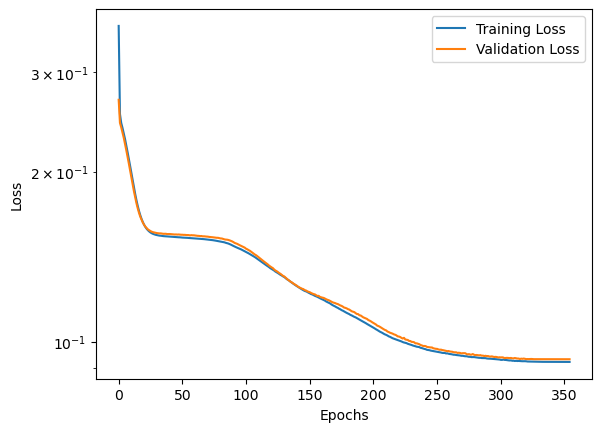

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')  # Apply logarithmic scale to y-axis

plt.legend()
plt.show()

In [33]:
y_pred_test = model.predict(X_test)
y_pred_test_rescaled = y_pred_test * (q - 1)
y_test_rescaled = y_test * (q - 1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    # print(f"predicted as is: ", y_pred_test[i])
    print(f"  Predicted:    {np.round(np.abs(y_pred_test_rescaled[i]))}")
    print(f"  Ground Truth: {np.round(np.abs(y_test_rescaled[i]))}")
    print("-" * 40)

7/7 [==============================] - 1s 2ms/step
Comparison of predictions and ground truth:
Sample 1:
  Predicted:    [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 1. 1. 4. 2.]
  Ground Truth: [1. 0. 1. 1. 1. 1. 3. 0. 1. 3. 1. 2. 1. 1. 4. 2.]
----------------------------------------
Sample 2:
  Predicted:    [2. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 3. 0. 1. 0.]
  Ground Truth: [4. 0. 2. 0. 2. 0. 3. 2. 1. 2. 2. 2. 3. 0. 1. 0.]
----------------------------------------
Sample 3:
  Predicted:    [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 3. 4. 4. 0. 1.]
  Ground Truth: [3. 2. 0. 0. 2. 0. 4. 4. 3. 3. 1. 3. 4. 3. 0. 1.]
----------------------------------------


In [34]:
num_unseen_samples = 3
# unseen_data = np.random.randint(0, q, size=(num_unseen_samples, n))
# unseen_data = np.array([3, 4, 2, 4, 4, 1, 2, 2, 2, 4, 3, 2, 4, 1, 3, 1])

unseen_data = np.array([
    [3, 4, 2, 4, 4, 1, 2, 2, 2, 4, 3, 2, 4, 1, 3, 1],
    [1, 3, 2, 4, 2, 1, 3, 4, 3, 2, 1, 4, 2, 3, 1, 4],
    [4, 2, 3, 1, 3, 4, 2, 1, 4, 3, 2, 1, 3, 2, 4, 1]
])  # Manually specified data


padded_unseen_data = np.hstack((unseen_data, np.zeros((num_unseen_samples, n_padded - n))))

unseen_data_normalized = unseen_data.astype(np.float32) / (q - 1)

# print("Unseen Input Data (Before Encoding):")
# print(unseen_data)

unseen_encoded = np.array([np.dot(M_tilde, x) for x in padded_unseen_data])
unseen_encoded[np.abs(unseen_encoded) < 1e-10] = 0
unseen_encoded = np.round(unseen_encoded, decimals=10)

k = np.arange(n_padded)
phase_shift = np.exp(-1j * np.pi * k / (2 * n_padded))
alpha_k = np.where(k == 0, np.sqrt(1/n_padded), np.sqrt(2/n_padded))

dct2_dataset_unseen = np.real(unseen_encoded * phase_shift) * alpha_k
dct2_dataset_unseen = np.round(dct2_dataset_unseen, 10)

mean_real = np.mean(dct2_dataset_unseen, axis=0)
std_real = np.std(dct2_dataset_unseen, axis=0) + 1e-8
dct2_dataset_unseen = (dct2_dataset_unseen - mean_real) / std_real

y_pred_unseen = model.predict(dct2_dataset_unseen)

y_pred_unseen_rescaled = y_pred_unseen * (q - 1)

y_pred_unseen_final = np.mod(np.round(y_pred_unseen_rescaled), q)

print("\nComparison of Unseen Data and Predictions:")
print("=" * 60)
for i in range(num_unseen_samples):
    print(f"Sample {i+1}:")
    print(f"  Prediction  : {y_pred_unseen_final[i].astype(int)}")
    print(f"  Ground Truth: {padded_unseen_data[i].astype(int)}")
    print("-" * 60)

1/1 [==============================] - 0s 42ms/step

Comparison of Unseen Data and Predictions:
Sample 1:
  Prediction  : [2 2 2 2 2 2 2 1 1 2 3 2 3 1 2 0]
  Ground Truth: [3 4 2 4 4 1 2 2 2 4 3 2 4 1 3 1]
------------------------------------------------------------
Sample 2:
  Prediction  : [2 2 2 2 0 2 2 3 2 2 2 3 3 3 1 0]
  Ground Truth: [1 3 2 4 2 1 3 4 3 2 1 4 2 3 1 4]
------------------------------------------------------------
Sample 3:
  Prediction  : [2 2 2 2 4 2 2 2 2 2 0 1 0 2 3 1]
  Ground Truth: [4 2 3 1 3 4 2 1 4 3 2 1 3 2 4 1]
------------------------------------------------------------


Check Gradient Flow

In [35]:
for layer in model.layers:
    if layer.trainable_variables:
        grads = tf.reduce_mean(tf.abs(layer.trainable_variables[0]))
        print(layer.name, "Gradient Mean:", grads.numpy())
    else:
        print(layer.name, "has no trainable variables.")

input has no trainable variables.
real_layer_1 Gradient Mean: 1.1781706
leaky_re_lu has no trainable variables.
real_support_layer_1 Gradient Mean: 1.7026582
leaky_re_lu_1 has no trainable variables.
real_layer_2 Gradient Mean: 1.3373591
leaky_re_lu_2 has no trainable variables.
real_support_layer_2 Gradient Mean: 1.2227685
leaky_re_lu_3 has no trainable variables.
real_layer_3 Gradient Mean: 1.1078273
leaky_re_lu_4 has no trainable variables.
output_layer Gradient Mean: 2.429224
activation has no trainable variables.


In [36]:
batch_size = 4 
X_dummy = np.random.rand(batch_size, X_train.shape[1]).astype(np.float32)
y_dummy = np.random.rand(batch_size, y_train.shape[1]).astype(np.float32)

def check_gradients(model, X_dummy, y_dummy):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        predictions = model(X_dummy, training=True)
        loss = tf.keras.losses.mean_squared_error(y_dummy, predictions)

    grads = tape.gradient(loss, model.trainable_variables)

    for i, (grad, var) in enumerate(zip(grads, model.trainable_variables)):
        if grad is None:
            print(f"🚨 Gradient is None for {var.name} at index {i}")
        else:
            print(f"✅ Gradient OK for {var.name}, mean: {tf.reduce_mean(grad).numpy()}")

check_gradients(model, X_dummy, y_dummy)

✅ Gradient OK for real_layer_1/kernel_d1:0, mean: -0.006991651840507984
✅ Gradient OK for real_layer_1/kernel_d2:0, mean: -0.009233171120285988
✅ Gradient OK for real_layer_1/bias:0, mean: -0.00024196412414312363
✅ Gradient OK for real_support_layer_1/kernel_m:0, mean: 0.00516069121658802
✅ Gradient OK for real_support_layer_1/bias:0, mean: 0.0058286855928599834
✅ Gradient OK for real_layer_2/kernel_d1:0, mean: 0.004125332925468683
✅ Gradient OK for real_layer_2/kernel_d2:0, mean: 0.018778635188937187
✅ Gradient OK for real_layer_2/kernel_w:0, mean: -0.059736695140600204
✅ Gradient OK for real_layer_2/kernel_C_1:0, mean: 0.02814575470983982
✅ Gradient OK for real_layer_2/kernel_C_2:0, mean: 0.02111365832388401
✅ Gradient OK for real_layer_2/bias:0, mean: -0.0006694813491776586
✅ Gradient OK for real_support_layer_2/kernel_m:0, mean: 0.006077839992940426
✅ Gradient OK for real_support_layer_2/bias:0, mean: -0.0007773307152092457
✅ Gradient OK for real_layer_3/kernel_w:0, mean: -0.011825